In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')
output=model.invoke("hi")
print(output.content)

Hi there! How can I help you today?


In [6]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

d:\D_Drive\DataWorld\Data_Science\GenAI\Agentic_AI_Gen_AI_Course\AgenticAI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


384

In [7]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [8]:
loader=DirectoryLoader("../data",glob="./usa.txt",loader_cls=TextLoader)

In [9]:
docs = loader.load()
docs

[Document(metadata={'source': '..\\data\\usa.txt'}, page_content="🇺🇸 Overview of the U.S. Economy\nThe United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.\n\nU.S. GDP – Size, Composition, and Global Share\nAs of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China (which ran

In [10]:
docs[0].page_content

"🇺🇸 Overview of the U.S. Economy\nThe United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.\n\nU.S. GDP – Size, Composition, and Global Share\nAs of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China (which ranks 2nd). The U.S. GDP per capita is also among the highest, hover

In [11]:
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

In [12]:
new_docs=text_splitter.split_documents(documents=docs)
new_docs[:2]

[Document(metadata={'source': '..\\data\\usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'),
 Document(metadata={'source': '..\\data\\usa.txt'}, page_content='The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,')]

In [13]:
doc_string=[doc.page_content for doc in new_docs]
doc_string[:2]

['🇺🇸 Overview of the U.S. Economy',
 'The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,']

In [14]:
len(doc_string)

55

In [15]:
db=Chroma.from_documents(new_docs,embeddings)

In [16]:
retriever=db.as_retriever(search_kwargs={"k": 3})

In [17]:
retriever.invoke("industrial growth of usa?")

[Document(metadata={'source': '..\\data\\usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administration’s Inflation'),
 Document(metadata={'source': '..\\data\\usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'),
 Document(metadata={'source': '..\\data\\usa.txt'}, page_content='The U.S. economy remains the engine of global growth, backed by unmatched innovation, financial dominance, and a strong institutional framework. Its $28 trillion GDP and influence over global')]

In [18]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [19]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

In [20]:
from langchain.output_parsers import PydanticOutputParser
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [21]:
from langgraph.graph import StateGraph,END

In [22]:
def supervisor(state:AgentState):
    question=state["messages"][-1]
    
    print("Question",question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [USA,Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    
    chain= prompt | model | parser
    
    response = chain.invoke({"question":question})
    
    print("Parsed response:", response)
    
    return {"messages": [response.Topic]}



In [23]:
state={"messages":["what is a today weather?"]}

In [24]:
supervisor(state)

Question what is a today weather?
Parsed response: Topic='Not Related' Reasoning='The query asks for the weather, which is not specific to the USA.'


{'messages': ['Not Related']}

In [25]:
def router(state:AgentState):
    print("-> ROUTER ->")
    
    last_message=state["messages"][-1]
    print("last_message:", last_message)
    
    if "usa" in last_message.lower():
        return "rag call"
    else:
        return "llm call"

In [26]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [27]:
def rag(state:AgentState):
    print("-> RAG Call ->")
    
    question = state["messages"][0]
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

In [28]:
def llm(state:AgentState):
    print("-> LLM Call ->")
    question = state["messages"][0]
    
    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"messages": [response.content]}

In [29]:
workflow=StateGraph(AgentState)

In [30]:
workflow.add_node("supervisor",supervisor)

In [31]:
workflow.add_node("rag",rag)

In [32]:
workflow.add_node("llm",llm)

In [33]:
workflow.set_entry_point("supervisor")


In [34]:
workflow.add_conditional_edges(
    "supervisor",
    router,
    {
        "rag call": "rag",
        "llm call": "llm",
        
    }
)

In [35]:
workflow.add_edge("rag",END)
workflow.add_edge("llm",END)

In [36]:
app = workflow.compile()

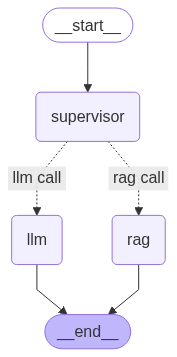

In [37]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [38]:
state={"messages":["can you tell me the industrial growth of world's most powerful economy?"]}

In [39]:
result = app.invoke(state)
result

Question can you tell me the industrial growth of world's most powerful economy?
Parsed response: Topic='USA' Reasoning="The query asks about the industrial growth of the world's most powerful economy, which is generally considered to be the USA."
-> ROUTER ->
last_message: USA
-> RAG Call ->


{'messages': ["can you tell me the industrial growth of world's most powerful economy?",
  'USA',
  "The provided text states the U.S. has a $28 trillion GDP and is the engine of global growth.  However, it doesn't give specific industrial growth figures.  Therefore, I cannot answer your question about the industrial growth rate."]}

In [40]:
result["messages"][-1]

"The provided text states the U.S. has a $28 trillion GDP and is the engine of global growth.  However, it doesn't give specific industrial growth figures.  Therefore, I cannot answer your question about the industrial growth rate."